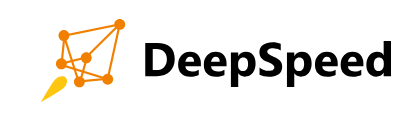

🤓 Porque utilizamos Deepspeed ---------> DIVIDE Y VENCERAS


ZERO ------> aprovecha al 100% la memoria de la GPU, no desperdicia nada, reparte los parametros del modelo en varias GPU.

Offload ------>  Lo que no cabe en las GPU, lo guarda en la RAM de la cpu.


Pipeline en paralelo. ---------> Todas las GPUS trabajan al tiempo.

In [1]:
# ============================================================
# INSTALACIÓN DE LIBRERÍAS PARA COMPARACIÓN DEEPSPEED
# ============================================================

# 🔥 LIBRERÍAS ESENCIALES (obligatorias)
%pip install transformers  # Para modelos y tokenizers
%pip install datasets      # Para manejo de datasets
%pip install deepspeed    # ⭐ La estrella del show!
%pip install huggingface_hub   # Para manejo de datasets y modelos
%pip install google-generativeai

# 🛠️ LIBRERÍAS DE SOPORTE (recomendadas)
%pip install accelerate    # Facilita integración con DeepSpeed
%pip install trl           # Para Supervised Fine-Tuning (SFT)

# 📊 MONITOREO Y VISUALIZACIÓN
%pip install psutil        # Monitor de CPU/RAM
%pip install GPUtil        # Monitor de GPU
%pip install matplotlib    # Gráficos
%pip install seaborn      # Gráficos bonitos
%pip install pandas       # Tablas de datos
%pip install numpy        # Operaciones numéricas



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00


In [2]:
from transformers import (
    AutoTokenizer,
    # AutoModelForCausalLM, # Moved to fe80618d
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset
from trl import SFTTrainer
import deepspeed
import time
import psutil
import GPUtil
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import os
import gc
import warnings
warnings.filterwarnings('ignore')

# Configurar para mostrar gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

[2025-07-24 01:09:25,361] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-07-24 01:09:27,606] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [3]:
class PerformanceMonitor:
    """Clase para monitorear rendimiento durante el entrenamiento"""

    def __init__(self):
        self.metrics = {
            'gpu_memory_used': [],
            'gpu_utilization': [],
            'cpu_percent': [],
            'ram_used': [],
            'timestamps': []
        }

    def start_monitoring(self):
        """Inicia el monitoreo de recursos"""
        self.start_time = time.time()

    def log_metrics(self):
        """Registra métricas actuales del sistema"""
        # GPU metrics
        if torch.cuda.is_available():
            gpu = GPUtil.getGPUs()[0] if GPUtil.getGPUs() else None
            if gpu:
                self.metrics['gpu_memory_used'].append(gpu.memoryUsed)
                self.metrics['gpu_utilization'].append(gpu.load * 100)
            else:
                self.metrics['gpu_memory_used'].append(0)
                self.metrics['gpu_utilization'].append(0)
        else:
            self.metrics['gpu_memory_used'].append(0)
            self.metrics['gpu_utilization'].append(0)

        # CPU y RAM
        self.metrics['cpu_percent'].append(psutil.cpu_percent())
        self.metrics['ram_used'].append(psutil.virtual_memory().used / (1024**3))  # GB
        self.metrics['timestamps'].append(time.time() - self.start_time)

    def get_average_metrics(self):
        """Calcula métricas promedio"""
        return {
            'avg_gpu_memory': np.mean(self.metrics['gpu_memory_used']) if self.metrics['gpu_memory_used'] else 0,
            'avg_gpu_utilization': np.mean(self.metrics['gpu_utilization']) if self.metrics['gpu_utilization'] else 0,
            'avg_cpu_percent': np.mean(self.metrics['cpu_percent']) if self.metrics['cpu_percent'] else 0,
            'avg_ram_used': np.mean(self.metrics['ram_used']) if self.metrics['ram_used'] else 0,
            'total_time': self.metrics['timestamps'][-1] if self.metrics['timestamps'] else 0
        }

def print_system_info():
    """Muestra información del sistema"""
    print("🖥️ INFORMACIÓN DEL SISTEMA")
    print("=" * 50)
    print(f"🐍 Python: {torch.__version__}")
    print(f"🔥 PyTorch: {torch.__version__}")
    print(f"🚀 CUDA disponible: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"📊 GPU: {torch.cuda.get_device_name(0)}")
        print(f"🎯 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"💾 RAM total: {psutil.virtual_memory().total / (1024**3):.1f} GB")
    print(f"🔄 CPUs: {psutil.cpu_count()}")
    print("=" * 50)


In [52]:
# ============================================================
# 📊 CREACIÓN DE DATASET SFT CON GEMINI - VERSIÓN CORREGIDA
# ============================================================

# Instalar dependencias necesarias
%pip install google-generativeai datasets pandas

import google.generativeai as genai
import random
import json
import pandas as pd
from datasets import Dataset
import numpy as np
import os
from datetime import datetime
import time

# ⚠️ CONFIGURAR API KEY DE GEMINI
# Opción 1: Usar tu API key directamente (RÁPIDO PARA TESTING)
GEMINI_API_KEY = 'apikey'  # Reemplaza con tu clave real

# Opción 2: Usar Colab Secrets (MÁS SEGURO)
# Descomenta las siguientes líneas si prefieres usar secrets:
"""
try:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    print("✅ API Key obtenida desde Colab Secrets")
except Exception as e:
    print(f"❌ Error al obtener de Secrets: {e}")
    GEMINI_API_KEY = None
"""

# Validar API key
if not GEMINI_API_KEY or GEMINI_API_KEY in ['YOUR_GEMINI_API_KEY_HERE', 'TU_API_KEY_AQUI']:
    print("❌ Por favor, reemplaza 'GEMINI_API_KEY' con tu clave real")
    print("🔗 Obtén tu key en: https://aistudio.google.com/app/apikey")
    model = None
else:
    try:
        # Configurar Gemini
        genai.configure(api_key=GEMINI_API_KEY)

        # Crear modelo con configuración optimizada
        model = genai.GenerativeModel(
            'gemini-1.5-flash-latest',
            generation_config=genai.GenerationConfig(
                temperature=0.9,
                top_p=0.95,
                max_output_tokens=800,
                candidate_count=1
            )
        )

        # Hacer una prueba rápida para verificar que funciona
        test_response = model.generate_content("Di solo 'OK' si puedes responder")
        if test_response.text:
            print("✅ Gemini configurado y funcionando correctamente")
            print(f"🔑 API Key válida (termina en: ...{GEMINI_API_KEY[-6:]})")
        else:
            print("⚠️ Modelo configurado pero respuesta vacía")

    except Exception as e:
        print(f"❌ Error configurando Gemini: {str(e)}")
        print("💡 Verifica que tu API key sea correcta y tenga permisos")
        model = None

def create_sft_dataset_with_gemini(num_samples=100, delay_between_requests=1):
    """
    Crea un dataset sintético de alta calidad usando Gemini
    para Supervised Fine-Tuning (SFT) de modelos de 3B parámetros.

    Args:
        num_samples (int): Número total de muestras a generar
        delay_between_requests (float): Delay en segundos entre requests para evitar rate limits

    Returns:
        Dataset: Dataset de Hugging Face con las conversaciones generadas
    """
    if not model:
        print("❌ Modelo Gemini no configurado. Revisa tu API key.")
        return Dataset.from_list([])

    # Categorías optimizadas para modelos de 3B
    sft_categories = [
        {
            "category": "conversacion_general",
            "weight": 0.25,
            "prompt": """Genera una conversación natural donde un usuario hace una pregunta cotidiana
            y el asistente responde de manera útil y amigable. La respuesta debe ser concisa pero completa.

            Ejemplos de temas: hobbies, consejos prácticos, explicaciones simples, recomendaciones.

            Formato exacto:
            Usuario: [pregunta natural y específica]
            Asistente: [respuesta útil de 50-150 palabras]"""
        },
        {
            "category": "ayuda_tecnica",
            "weight": 0.20,
            "prompt": """Genera una conversación donde el usuario pide ayuda técnica básica
            y el asistente da una solución clara y paso a paso.

            Ejemplos: programación básica, uso de software, troubleshooting simple.

            Formato exacto:
            Usuario: [problema técnico específico]
            Asistente: [solución paso a paso de 100-200 palabras]"""
        },
        {
            "category": "educativo",
            "weight": 0.20,
            "prompt": """Genera una conversación educativa donde el usuario pregunta sobre un concepto
            y el asistente explica de manera clara con ejemplos prácticos.

            Ejemplos: ciencia básica, historia, matemáticas, idiomas.

            Formato exacto:
            Usuario: [pregunta educativa]
            Asistente: [explicación clara con ejemplos de 100-200 palabras]"""
        },
        {
            "category": "creatividad",
            "weight": 0.15,
            "prompt": """Genera una conversación donde el usuario pide ayuda creativa
            y el asistente ofrece ideas originales y útiles.

            Ejemplos: escritura, ideas para proyectos, soluciones creativas.

            Formato exacto:
            Usuario: [solicitud creativa]
            Asistente: [respuesta creativa e inspiradora de 80-180 palabras]"""
        },
        {
            "category": "etica_seguridad",
            "weight": 0.20,
            "prompt": """Genera una conversación donde el usuario hace una pregunta que requiere
            una respuesta responsable, y el asistente responde éticamente explicando consideraciones importantes.

            Formato exacto:
            Usuario: [pregunta que requiere consideraciones éticas]
            Asistente: [respuesta responsable y educativa de 100-200 palabras]"""
        }
    ]

    dataset_entries = []

    # Calcular muestras por categoría basado en pesos
    samples_distribution = {}
    for cat in sft_categories:
        samples_distribution[cat["category"]] = int(num_samples * cat["weight"])

    # Ajustar para que sume exactamente num_samples
    total_assigned = sum(samples_distribution.values())
    if total_assigned < num_samples:
        # Agregar muestras faltantes a la primera categoría
        first_cat = sft_categories[0]["category"]
        samples_distribution[first_cat] += (num_samples - total_assigned)

    print(f"🎯 Generando {num_samples} muestras distribuidas como:")
    for cat, count in samples_distribution.items():
        print(f"  • {cat}: {count} muestras")

    total_generated = 0

    for category_info in sft_categories:
        category = category_info["category"]
        target_samples = samples_distribution[category]

        if target_samples == 0:
            continue

        print(f"\n🔄 Generando categoría: {category} ({target_samples} muestras)")

        category_generated = 0
        attempts = 0
        max_attempts = target_samples * 3  # Máximo 3 intentos por muestra objetivo

        while category_generated < target_samples and attempts < max_attempts:
            attempts += 1

            try:
                # Añadir variación al prompt
                variation_prompt = f"""
                {category_info["prompt"]}

                IMPORTANTE:
                - Genera SOLO UNA conversación
                - Usa un tema específico y diferente cada vez
                - La respuesta del asistente debe ser natural y humana
                - NO incluyas explicaciones adicionales
                - Responde EXACTAMENTE en el formato Usuario:/Asistente:

                Variación #{attempts}: Cambia el tema y contexto específico.
                """

                # Generar con Gemini
                response = model.generate_content(variation_prompt)

                if not response.text:
                    print(f"  ⚠️  Respuesta vacía en intento {attempts}")
                    continue

                generated_text = response.text.strip()

                # Procesar respuesta
                if process_gemini_response(generated_text, category, dataset_entries):
                    category_generated += 1
                    total_generated += 1
                    print(f"  ✅ {category_generated}/{target_samples} - Total: {total_generated}/{num_samples}")
                else:
                    print(f"  ⚠️  Formato incorrecto en intento {attempts}")

                # Delay para evitar rate limits
                if delay_between_requests > 0:
                    time.sleep(delay_between_requests)

            except Exception as e:
                error_msg = str(e)
                print(f"  ❌ Error en intento {attempts}: {error_msg}")

                if "quota" in error_msg.lower() or "rate" in error_msg.lower():
                    print("  ⏸️  Rate limit detectado, esperando 10 segundos...")
                    time.sleep(10)
                elif "blocked" in error_msg.lower():
                    print("  🚫 Contenido bloqueado, intentando con otro tema...")
                    continue
                else:
                    time.sleep(2)  # Pausa corta para otros errores

    print(f"\n📦 Dataset creado con {len(dataset_entries)} muestras válidas")
    return Dataset.from_list(dataset_entries)

def _process_gemini_response(self, generated_text, category, dataset_entries):
    """Procesa la respuesta de Gemini y la añade al dataset si es válida"""
    try:
        # Buscar patrones Usuario:/Asistente:
        lines = generated_text.split('\n')
        user_text = None
        assistant_text = None

        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith('Usuario:'):
                user_text = line[8:].strip()
            elif line.startswith('Asistente:'):
                # Tomar todo lo que sigue como respuesta del asistente
                assistant_lines = [line[10:].strip()]
                for j in range(i+1, len(lines)):
                    if not lines[j].strip().startswith('Usuario:'):
                        assistant_lines.append(lines[j].strip())
                    else:
                        break
                assistant_text = ' '.join(assistant_lines).strip()
                break

        # Validar que tenemos ambas partes
        if not user_text or not assistant_text:
            return False

        # Validar longitudes mínimas
        if len(user_text) < 10 or len(assistant_text) < 30:
            return False

        # Crear entrada en formato estándar para SFT
        conversation = f"<|user|>\n{user_text}\n<|assistant|>\n{assistant_text}<|end|>"

        dataset_entries.append({
            "text": conversation,
            "category": category,
            "user_message": user_text,
            "assistant_message": assistant_text,
            "length": len(conversation),
            "tokens_estimate": len(conversation.split()),
            "created_at": datetime.now().isoformat()
        })

        return True

    except Exception as e:
        print(f"    ❌ Error procesando respuesta: {e}")
        return False

# Corregir el método como función independiente
def process_gemini_response(generated_text, category, dataset_entries):
    """Procesa la respuesta de Gemini y la añade al dataset si es válida"""
    try:
        # Buscar patrones Usuario:/Asistente:
        lines = generated_text.split('\n')
        user_text = None
        assistant_text = None

        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith('Usuario:'):
                user_text = line[8:].strip()
            elif line.startswith('Asistente:'):
                # Tomar todo lo que sigue como respuesta del asistente
                assistant_lines = [line[10:].strip()]
                for j in range(i+1, len(lines)):
                    if not lines[j].strip().startswith('Usuario:'):
                        assistant_lines.append(lines[j].strip())
                    else:
                        break
                assistant_text = ' '.join(assistant_lines).strip()
                break

        # Validar que tenemos ambas partes
        if not user_text or not assistant_text:
            return False

        # Validar longitudes mínimas
        if len(user_text) < 10 or len(assistant_text) < 30:
            return False

        # Crear entrada en formato estándar para SFT
        conversation = f"<|user|>\n{user_text}\n<|assistant|>\n{assistant_text}<|end|>"

        dataset_entries.append({
            "text": conversation,
            "category": category,
            "user_message": user_text,
            "assistant_message": assistant_text,
            "length": len(conversation),
            "tokens_estimate": len(conversation.split()),
            "created_at": datetime.now().isoformat()
        })

        return True

    except Exception as e:
        print(f"    ❌ Error procesando respuesta: {e}")
        return False

def show_dataset_stats(dataset):
    """Muestra estadísticas detalladas del dataset"""
    print("\n📈 ESTADÍSTICAS DEL DATASET SFT")
    print("=" * 60)

    if len(dataset) == 0:
        print("❌ Dataset vacío")
        return

    # Estadísticas básicas
    lengths = [item['length'] for item in dataset]
    tokens = [item['tokens_estimate'] for item in dataset]

    print(f"📊 Total de muestras: {len(dataset)}")
    print(f"📏 Longitud promedio: {np.mean(lengths):.1f} caracteres")
    print(f"📏 Longitud mediana: {np.median(lengths):.1f} caracteres")
    print(f"🎯 Tokens promedio: {np.mean(tokens):.1f}")
    print(f"🎯 Tokens mediana: {np.median(tokens):.1f}")

    # Distribución por categorías
    if 'category' in dataset.column_names:
        categories = {}
        for item in dataset:
            cat = item['category']
            categories[cat] = categories.get(cat, 0) + 1

        print("\n🏷️  DISTRIBUCIÓN POR CATEGORÍAS:")
        for cat, count in sorted(categories.items()):
            percentage = (count / len(dataset)) * 100
            print(f"  • {cat}: {count} muestras ({percentage:.1f}%)")

    # Ejemplo de conversación
    print("\n📝 EJEMPLO DE CONVERSACIÓN GENERADA:")
    print("-" * 60)
    example = dataset[0]['text']
    print(example)
    print("-" * 60)

def save_dataset_locally(dataset, base_dir="./sft_dataset"):
    """
    Guarda el dataset localmente en múltiples formatos

    Args:
        dataset: Dataset de Hugging Face
        base_dir: Directorio base donde guardar
    """
    if len(dataset) == 0:
        print("⚠️  Dataset vacío, no se guardará")
        return

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"{base_dir}_{timestamp}"

    try:
        # Crear directorio
        os.makedirs(output_dir, exist_ok=True)

        # 1. Guardar en formato Hugging Face Dataset
        dataset.save_to_disk(os.path.join(output_dir, "hf_dataset"))
        print(f"✅ Dataset HF guardado en: {output_dir}/hf_dataset")

        # 2. Guardar como JSON Lines (formato común para fine-tuning)
        jsonl_path = os.path.join(output_dir, "dataset.jsonl")
        with open(jsonl_path, 'w', encoding='utf-8') as f:
            for item in dataset:
                json.dump(item, f, ensure_ascii=False)
                f.write('\n')
        print(f"✅ JSONL guardado en: {jsonl_path}")

        # 3. Guardar como CSV para análisis
        df = dataset.to_pandas()
        csv_path = os.path.join(output_dir, "dataset.csv")
        df.to_csv(csv_path, index=False, encoding='utf-8')
        print(f"✅ CSV guardado en: {csv_path}")

        # 4. Guardar solo el texto para fine-tuning directo
        text_path = os.path.join(output_dir, "conversations.txt")
        with open(text_path, 'w', encoding='utf-8') as f:
            for i, item in enumerate(dataset):
                f.write(f"# Conversación {i+1}\n")
                f.write(item['text'])
                f.write('\n\n' + '='*50 + '\n\n')
        print(f"✅ Texto plano guardado en: {text_path}")

        # 5. Crear archivo de metadatos
        metadata = {
            "total_samples": len(dataset),
            "creation_date": datetime.now().isoformat(),
            "average_length": float(np.mean([item['length'] for item in dataset])),
            "average_tokens": float(np.mean([item['tokens_estimate'] for item in dataset])),
            "categories": {}
        }

        # Agregar distribución de categorías
        for item in dataset:
            cat = item['category']
            metadata["categories"][cat] = metadata["categories"].get(cat, 0) + 1

        metadata_path = os.path.join(output_dir, "metadata.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        print(f"✅ Metadatos guardados en: {metadata_path}")

        print(f"\n🎉 Dataset completo guardado en: {output_dir}")
        print(f"📁 Contiene: HF Dataset, JSONL, CSV, TXT y metadatos")

        return output_dir

    except Exception as e:
        print(f"❌ Error guardando dataset: {e}")
        return None

def load_dataset_from_local(dataset_path):
    """
    Carga un dataset desde disco

    Args:
        dataset_path: Ruta al directorio del dataset o archivo específico

    Returns:
        Dataset: Dataset cargado
    """
    try:
        if os.path.isdir(dataset_path):
            # Si es un directorio, buscar el dataset de HF
            hf_path = os.path.join(dataset_path, "hf_dataset")
            if os.path.exists(hf_path):
                dataset = Dataset.load_from_disk(hf_path)
                print(f"✅ Dataset cargado desde: {hf_path}")
                return dataset

            # Si no, buscar JSONL
            jsonl_path = os.path.join(dataset_path, "dataset.jsonl")
            if os.path.exists(jsonl_path):
                data = []
                with open(jsonl_path, 'r', encoding='utf-8') as f:
                    for line in f:
                        data.append(json.loads(line))
                dataset = Dataset.from_list(data)
                print(f"✅ Dataset cargado desde JSONL: {jsonl_path}")
                return dataset

        elif dataset_path.endswith('.jsonl'):
            # Cargar directamente desde JSONL
            data = []
            with open(dataset_path, 'r', encoding='utf-8') as f:
                for line in f:
                    data.append(json.loads(line))
            dataset = Dataset.from_list(data)
            print(f"✅ Dataset cargado desde: {dataset_path}")
            return dataset

        print(f"❌ No se pudo encontrar dataset en: {dataset_path}")
        return Dataset.from_list([])

    except Exception as e:
        print(f"❌ Error cargando dataset: {e}")
        return Dataset.from_list([])

# 🚀 EJECUCIÓN PRINCIPAL
print("🚀 GENERADOR DE DATASET SFT PARA MODELOS 3B")
print("=" * 60)

if model:
    # Generar dataset
    print("🎯 Iniciando generación...")
    dataset = create_sft_dataset_with_gemini(
        num_samples=800,  # Empezar con 2500 para testing
        delay_between_requests=1.5  # 1.5 segundos entre requests
    )

    # Mostrar estadísticas
    show_dataset_stats(dataset)

    # Guardar localmente
    if len(dataset) > 0:
        saved_path = save_dataset_locally(dataset)

        if saved_path:
            print(f"\n🎉 ¡Dataset creado exitosamente!")
            print(f"📍 Ubicación: {saved_path}")
            print(f"📊 {len(dataset)} muestras de alta calidad")

            # Mostrar cómo cargar el dataset
            print(f"\n💡 Para cargar el dataset más tarde:")
            print(f"dataset = load_dataset_from_local('{saved_path}')")
    else:
        print("\n❌ No se pudieron generar muestras. Revisa tu API key y configuración.")
else:
    print("❌ Configuración incompleta. Revisa tu API key de Gemini.")

print("\n✅ Script completado")

✅ Gemini configurado y funcionando correctamente
🔑 API Key válida (termina en: ...KpnitY)
🚀 GENERADOR DE DATASET SFT PARA MODELOS 3B
🎯 Iniciando generación...
🎯 Generando 800 muestras distribuidas como:
  • conversacion_general: 200 muestras
  • ayuda_tecnica: 160 muestras
  • educativo: 160 muestras
  • creatividad: 120 muestras
  • etica_seguridad: 160 muestras

🔄 Generando categoría: conversacion_general (200 muestras)
  ✅ 1/200 - Total: 1/800
  ✅ 2/200 - Total: 2/800
  ✅ 3/200 - Total: 3/800
  ✅ 4/200 - Total: 4/800
  ✅ 5/200 - Total: 5/800
  ✅ 6/200 - Total: 6/800
  ✅ 7/200 - Total: 7/800
  ✅ 8/200 - Total: 8/800
  ✅ 9/200 - Total: 9/800
  ✅ 10/200 - Total: 10/800
  ✅ 11/200 - Total: 11/800
  ✅ 12/200 - Total: 12/800
  ✅ 13/200 - Total: 13/800
  ✅ 14/200 - Total: 14/800
  ✅ 15/200 - Total: 15/800
  ✅ 16/200 - Total: 16/800
  ✅ 17/200 - Total: 17/800
  ✅ 18/200 - Total: 18/800
  ✅ 19/200 - Total: 19/800
  ✅ 20/200 - Total: 20/800
  ✅ 21/200 - Total: 21/800
  ✅ 22/200 - Total: 22/80

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 327.62ms


  ✅ 54/160 - Total: 694/800
  ✅ 55/160 - Total: 695/800
  ✅ 56/160 - Total: 696/800
  ✅ 57/160 - Total: 697/800
  ✅ 58/160 - Total: 698/800
  ✅ 59/160 - Total: 699/800
  ✅ 60/160 - Total: 700/800
  ✅ 61/160 - Total: 701/800
  ✅ 62/160 - Total: 702/800
  ✅ 63/160 - Total: 703/800
  ✅ 64/160 - Total: 704/800
  ✅ 65/160 - Total: 705/800
  ✅ 66/160 - Total: 706/800
  ✅ 67/160 - Total: 707/800
  ✅ 68/160 - Total: 708/800
  ✅ 69/160 - Total: 709/800
  ✅ 70/160 - Total: 710/800
  ✅ 71/160 - Total: 711/800


ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 428.04ms


  ✅ 72/160 - Total: 712/800
  ✅ 73/160 - Total: 713/800
  ✅ 74/160 - Total: 714/800
  ✅ 75/160 - Total: 715/800
  ✅ 76/160 - Total: 716/800
  ✅ 77/160 - Total: 717/800
  ✅ 78/160 - Total: 718/800
  ✅ 79/160 - Total: 719/800
  ✅ 80/160 - Total: 720/800
  ✅ 81/160 - Total: 721/800
  ✅ 82/160 - Total: 722/800
  ✅ 83/160 - Total: 723/800
  ✅ 84/160 - Total: 724/800
  ✅ 85/160 - Total: 725/800
  ✅ 86/160 - Total: 726/800
  ✅ 87/160 - Total: 727/800
  ✅ 88/160 - Total: 728/800
  ✅ 89/160 - Total: 729/800
  ✅ 90/160 - Total: 730/800
  ✅ 91/160 - Total: 731/800
  ✅ 92/160 - Total: 732/800
  ✅ 93/160 - Total: 733/800
  ✅ 94/160 - Total: 734/800
  ✅ 95/160 - Total: 735/800
  ✅ 96/160 - Total: 736/800
  ✅ 97/160 - Total: 737/800
  ✅ 98/160 - Total: 738/800
  ✅ 99/160 - Total: 739/800
  ✅ 100/160 - Total: 740/800
  ✅ 101/160 - Total: 741/800
  ✅ 102/160 - Total: 742/800
  ✅ 103/160 - Total: 743/800
  ✅ 104/160 - Total: 744/800
  ✅ 105/160 - Total: 745/800
  ✅ 106/160 - Total: 746/800
  ✅ 107/160 -

Saving the dataset (0/1 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

✅ Dataset HF guardado en: ./sft_dataset_20250724_034613/hf_dataset
✅ JSONL guardado en: ./sft_dataset_20250724_034613/dataset.jsonl
✅ CSV guardado en: ./sft_dataset_20250724_034613/dataset.csv
✅ Texto plano guardado en: ./sft_dataset_20250724_034613/conversations.txt
✅ Metadatos guardados en: ./sft_dataset_20250724_034613/metadata.json

🎉 Dataset completo guardado en: ./sft_dataset_20250724_034613
📁 Contiene: HF Dataset, JSONL, CSV, TXT y metadatos

🎉 ¡Dataset creado exitosamente!
📍 Ubicación: ./sft_dataset_20250724_034613
📊 800 muestras de alta calidad

💡 Para cargar el dataset más tarde:
dataset = load_dataset_from_local('./sft_dataset_20250724_034613')

✅ Script completado


In [53]:
# ⚠️ WARNING: Pasting your token directly is INSECURE. Use Colab Secrets instead.
# You can get a token from: https://huggingface.co/settings/tokens

HF_TOKEN = "hf_token"

# You can optionally log in programmatically using the token
from huggingface_hub import login

if HF_TOKEN and HF_TOKEN != "PASTE_YOUR_HF_TOKEN_HERE":
    print("Attempting to log in to Hugging Face Hub with explicit token...")
    try:
        login(token=HF_TOKEN)
        print("✅ Logged in to Hugging Face Hub programmatically.")
    except Exception as e:
        print(f"❌ Failed to log in to Hugging Face Hub programmatically: {e}")
        print("💡 Please double-check your token.")
else:
    print("⚠️  Hugging Face token placeholder not replaced or is empty.")
    print("💡 Please replace 'PASTE_YOUR_HF_TOKEN_HERE' with your actual token.")


# Note: After successful login, the tokenizer and model loading in subsequent cells
# should use this authentication.

Attempting to log in to Hugging Face Hub with explicit token...
✅ Logged in to Hugging Face Hub programmatically.


In [44]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM, # Import AutoModelForCausalLM here
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)


# Configuración del modelo
MODEL_NAME = "mistralai/Mistral-7B-v0.1"  # Modelo pequeño para demostración
MAX_LENGTH = 128 # Reduced MAX_LENGTH to save memory
BATCH_SIZE = 4
NUM_EPOCHS = 1
LEARNING_RATE = 2e-5

print(f"\n🤖 Configuración del modelo:")
print(f"📦 Modelo: {MODEL_NAME}")
print(f"📏 Longitud máxima: {MAX_LENGTH}")
print(f"🔢 Batch size: {BATCH_SIZE}")
print(f"🔄 Épocas: {NUM_EPOCHS}")
print(f"📈 Learning rate: {LEARNING_RATE}")

# Cargar tokenizer y modelo (usará la autenticación de Hugging Face si se hizo login)
print("\n🔤 Cargando tokenizer y modelo...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Cargar el modelo directamente usando AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

print("✅ Tokenizer y modelo cargados correctamente")


🤖 Configuración del modelo:
📦 Modelo: mistralai/Mistral-7B-v0.1
📏 Longitud máxima: 128
🔢 Batch size: 4
🔄 Épocas: 1
📈 Learning rate: 2e-05

🔤 Cargando tokenizer y modelo...


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

✅ Tokenizer y modelo cargados correctamente


In [54]:
def preprocess_function(examples):
    """Preprocesa los datos para el entrenamiento"""
    # Tokenizar los textos
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    # Para language modeling, labels = input_ids
    tokenized["labels"] = tokenized["input_ids"].clone()

    return tokenized

# Preprocesar dataset
print("🔄 Preprocesando dataset...")
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset.column_names
)

# Dividir en train/test
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"✅ Datos preparados:")
print(f"🎯 Training samples: {len(train_dataset)}")
print(f"📊 Evaluation samples: {len(eval_dataset)}")

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # No masked language modeling para GPT
)


🔄 Preprocesando dataset...


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

✅ Datos preparados:
🎯 Training samples: 720
📊 Evaluation samples: 80


## ⚡ Paso 8: Configuración de DeepSpeed

Como lo Hace ?

ZERO -Offload:  Utiliza GPU para calculos  rapidos y CPU para calculos secundarios.

Sacrfica la presicion de entrenamiento:  FP16: entrena en 16 bits en ves de 32 como lo hicieron con Deepseek.

In [55]:
import json
import torch
import os

def create_optimized_deepspeed_config(dataset_size=None, model_size="2b", gpu_memory_gb=40):
    """
    Crea configuración DeepSpeed optimizada basada en características del entrenamiento

    Args:
        dataset_size: Número de samples en el dataset
        model_size: Tamaño del modelo ("2b", "7b", "13b", etc.)
        gpu_memory_gb: Memoria GPU disponible en GB
    """

    # 🎯 CONFIGURACIÓN BASE OPTIMIZADA
    base_config = {
        "fp16": {
            "enabled": "auto",
            "loss_scale": 0,  # Dynamic loss scaling
            "loss_scale_window": 1000,
            "initial_scale_power": 16,
            "hysteresis": 2,
            "min_loss_scale": 1
        },
        "bf16": {
            "enabled": False  # FP16 es mejor para GPUs más antiguas
        },
        "optimizer": {
            "type": "AdamW",
            "params": {
                "lr": "auto",
                "betas": "auto",
                "eps": "auto",
                "weight_decay": "auto"
            }
        },
        "scheduler": {
            "type": "WarmupLR",
            "params": {
                "warmup_min_lr": "auto",
                "warmup_max_lr": "auto",
                "warmup_num_steps": "auto"
            }
        },
        "gradient_accumulation_steps": "auto",
        "gradient_clipping": "auto",
        "steps_per_print": 50,  # Más frecuente para debugging
        "train_batch_size": "auto",
        "train_micro_batch_size_per_gpu": "auto",
        "wall_clock_breakdown": False
    }

    # 🚀 OPTIMIZACIONES DINÁMICAS BASADAS EN DATASET
    if dataset_size and dataset_size < 1000:
        # Dataset pequeño: Optimizar para latencia
        print("📊 Dataset pequeño detectado - Optimizando para latencia...")
        zero_config = {
            "stage": 1,  # ZeRO Stage 1 para datasets pequeños
            "allgather_partitions": True,
            "allgather_bucket_size": 5e7,  # Buckets más pequeños
            "overlap_comm": True,
            "reduce_scatter": True,
            "reduce_bucket_size": 5e7,
            "contiguous_gradients": True,
            # Sin CPU offloading para datasets pequeños
            "cpu_offload": False
        }
    elif dataset_size and dataset_size < 10000:
        # Dataset mediano: Balance memoria/velocidad
        print("📊 Dataset mediano detectado - Balance memoria/velocidad...")
        zero_config = {
            "stage": 2,
            "offload_optimizer": {
                "device": "cpu",
                "pin_memory": True,
                "buffer_count": 4,
                "fast_init": False
            },
            "allgather_partitions": True,
            "allgather_bucket_size": 1e8,
            "overlap_comm": True,
            "reduce_scatter": True,
            "reduce_bucket_size": 1e8,
            "contiguous_gradients": True
        }
    else:
        # Dataset grande: Máxima eficiencia de memoria
        print("📊 Dataset grande detectado - Máxima eficiencia de memoria...")
        zero_config = {
            "stage": 3,  # ZeRO Stage 3 para máximo ahorro
            "offload_optimizer": {
                "device": "cpu",
                "pin_memory": True,
                "buffer_count": 4,
                "fast_init": False
            },
            "offload_param": {
                "device": "cpu",
                "pin_memory": True,
                "buffer_count": 5,
                "buffer_size": 1e8,
                "max_in_cpu": 1e9
            },
            "allgather_partitions": True,
            "allgather_bucket_size": 2e8,  # Buckets más grandes
            "overlap_comm": True,
            "reduce_scatter": True,
            "reduce_bucket_size": 2e8,
            "contiguous_gradients": True,
            "sub_group_size": 1e9,
            "prefetch_bucket_size": 5e7,
            "param_persistence_threshold": 1e5
        }

    base_config["zero_optimization"] = zero_config

    # 🎯 OPTIMIZACIONES ESPECÍFICAS PARA GEMMA-2B
    if model_size == "2b":
        print("🤖 Optimizaciones específicas para Gemma-2B...")

        # Activar compilation para modelos pequeños
        base_config["compilation"] = {
            "enabled": False  # Deshabilitado por compatibilidad inicial
        }

        # Configurar comunicación óptima
        base_config["comms_logger"] = {
            "enabled": False,
            "verbose": False
        }

        # Optimizar para throughput
        base_config["steps_per_print"] = 20

    # 🔧 OPTIMIZACIONES AVANZADAS
    advanced_optimizations = {
        # Activation checkpointing inteligente
        "activation_checkpointing": {
            "partition_activations": True,
            "cpu_checkpointing": False,  # Mantener en GPU para modelos pequeños
            "contiguous_memory_optimization": True,
            "number_checkpoints": 4,
            "synchronize_checkpoint_boundary": True
        },

        # Optimizaciones de tensor
        "tensor_fusion": {
            "enabled": True,
            "max_fusion_size": 1000000
        },

        # Configuración de memoria
        "memory_breakdown": {
            "enabled": False  # Solo para debugging
        },

        # Logging optimizado
        "tensorboard": {
            "enabled": False,
            "output_path": "./deepspeed_logs",
            "job_name": "gemma_training"
        }
    }

    # Agregar optimizaciones avanzadas solo si es beneficioso
    if dataset_size and dataset_size > 100:
        base_config.update(advanced_optimizations)

    return base_config

def create_ultra_optimized_configs():
    """
    Crea múltiples configuraciones para diferentes escenarios
    """
    configs = {}

    # 🚀 CONFIGURACIÓN PARA DATASETS PEQUEÑOS (<1000 samples)
    configs["small_dataset"] = {
        "fp16": {"enabled": "auto"},
        "optimizer": {
            "type": "AdamW",
            "params": {"lr": "auto", "betas": "auto", "eps": "auto", "weight_decay": "auto"}
        },
        "zero_optimization": {
            "stage": 1,  # Mínimo overhead
            "allgather_partitions": True,
            "overlap_comm": False,  # Menos overhead para datasets pequeños
            "contiguous_gradients": True
        },
        "gradient_accumulation_steps": "auto",
        "train_batch_size": "auto",
        "train_micro_batch_size_per_gpu": "auto",
        "steps_per_print": 10
    }

    # ⚡ CONFIGURACIÓN PARA MÁXIMA VELOCIDAD
    configs["max_speed"] = {
        "fp16": {"enabled": "auto"},
        "optimizer": {
            "type": "AdamW",
            "params": {"lr": "auto", "betas": [0.9, 0.999], "eps": 1e-8, "weight_decay": "auto"}
        },
        "zero_optimization": {
            "stage": 2,
            "allgather_partitions": True,
            "allgather_bucket_size": 5e7,  # Buckets pequeños para baja latencia
            "overlap_comm": True,
            "reduce_scatter": True,
            "reduce_bucket_size": 5e7,
            "contiguous_gradients": True
        },
        "gradient_accumulation_steps": "auto",
        "train_batch_size": "auto",
        "train_micro_batch_size_per_gpu": "auto",
        "activation_checkpointing": {
            "partition_activations": False,  # Desactivar para velocidad
            "cpu_checkpointing": False
        }
    }

    # 💾 CONFIGURACIÓN PARA MÁXIMO AHORRO DE MEMORIA
    configs["max_memory"] = {
        "fp16": {"enabled": "auto"},
        "optimizer": {
            "type": "AdamW",
            "params": {"lr": "auto", "betas": "auto", "eps": "auto", "weight_decay": "auto"}
        },
        "zero_optimization": {
            "stage": 3,  # Máximo ahorro
            "offload_optimizer": {
                "device": "cpu",
                "pin_memory": True,
                "buffer_count": 4
            },
            "offload_param": {
                "device": "cpu",
                "pin_memory": True,
                "buffer_count": 5,
                "buffer_size": 1e8
            },
            "allgather_partitions": True,
            "allgather_bucket_size": 2e8,
            "overlap_comm": True,
            "reduce_scatter": True,
            "reduce_bucket_size": 2e8,
            "contiguous_gradients": True,
            "sub_group_size": 1e9
        },
        "activation_checkpointing": {
            "partition_activations": True,
            "cpu_checkpointing": True,  # Activar CPU checkpointing
            "contiguous_memory_optimization": True
        }
    }

    return configs

# 🎯 FUNCIÓN PRINCIPAL DE CONFIGURACIÓN
def setup_optimized_deepspeed(dataset_size=45, model_name="google/gemma-2b", optimization_target="balanced"):
    """
    Configura DeepSpeed de forma óptima

    Args:
        dataset_size: Tamaño del dataset
        model_name: Nombre del modelo
        optimization_target: "speed", "memory", "balanced", "small_dataset"
    """

    print("⚡ CONFIGURANDO DEEPSPEED OPTIMIZADO")
    print("=" * 50)
    print(f"📊 Dataset size: {dataset_size}")
    print(f"🤖 Modelo: {model_name}")
    print(f"🎯 Target: {optimization_target}")
    print("=" * 50)

    # Detectar características del modelo
    model_size = "2b" if "2b" in model_name.lower() else "7b" if "7b" in model_name.lower() else "unknown"
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else 40

    # Crear configuraciones
    if optimization_target == "small_dataset" or dataset_size < 100:
        print("🎯 Usando configuración optimizada para dataset pequeño")
        configs = create_ultra_optimized_configs()
        deepspeed_config = configs["small_dataset"]
        config_name = "deepspeed_small_dataset.json"

    elif optimization_target == "speed":
        print("🎯 Usando configuración optimizada para velocidad")
        configs = create_ultra_optimized_configs()
        deepspeed_config = configs["max_speed"]
        config_name = "deepspeed_speed.json"

    elif optimization_target == "memory":
        print("🎯 Usando configuración optimizada para memoria")
        configs = create_ultra_optimized_configs()
        deepspeed_config = configs["max_memory"]
        config_name = "deepspeed_memory.json"

    else:  # balanced
        print("🎯 Usando configuración balanceada")
        deepspeed_config = create_optimized_deepspeed_config(dataset_size, model_size, gpu_memory)
        config_name = "deepspeed_balanced.json"

    # Guardar configuración
    with open(config_name, "w") as f:
        json.dump(deepspeed_config, f, indent=2)

    # Mostrar resumen de optimizaciones
    print("\n✅ OPTIMIZACIONES ACTIVADAS:")

    zero_stage = deepspeed_config.get("zero_optimization", {}).get("stage", 0)
    print(f"  🔢 ZeRO Stage: {zero_stage}")

    if deepspeed_config.get("fp16", {}).get("enabled"):
        print("  ✅ FP16 (Half Precision)")

    if "offload_optimizer" in deepspeed_config.get("zero_optimization", {}):
        print("  ✅ CPU Optimizer Offload")

    if "offload_param" in deepspeed_config.get("zero_optimization", {}):
        print("  ✅ CPU Parameter Offload")

    if deepspeed_config.get("zero_optimization", {}).get("overlap_comm"):
        print("  ✅ Communication Overlap")

    if "activation_checkpointing" in deepspeed_config:
        print("  ✅ Activation Checkpointing")

    print(f"  📁 Configuración guardada: {config_name}")
    print("=" * 50)

    return config_name, deepspeed_config

# 🚀 CONFIGURACIÓN AUTOMÁTICA INTELIGENTE
def auto_configure_deepspeed():
    """
    Configuración automática basada en recursos disponibles
    """

    # Detectar recursos
    gpu_available = torch.cuda.is_available()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9 if gpu_available else 0
    cpu_count = os.cpu_count()

    print("🔍 DETECCIÓN AUTOMÁTICA DE RECURSOS")
    print("=" * 40)
    print(f"🎯 GPU disponible: {gpu_available}")
    print(f"💾 Memoria GPU: {gpu_memory:.1f} GB")
    print(f"🔄 CPUs: {cpu_count}")

    # Decidir configuración óptima
    if gpu_memory > 32:
        target = "speed"
        print("🚀 Configuración recomendada: VELOCIDAD")
    elif gpu_memory > 16:
        target = "balanced"
        print("⚖️ Configuración recomendada: BALANCEADA")
    else:
        target = "memory"
        print("💾 Configuración recomendada: MEMORIA")

    return target

# ============================================================
# 🚀 EJECUCIÓN DE EJEMPLO
# ============================================================

if __name__ == "__main__":
    # Configuración automática
    target = auto_configure_deepspeed()

    # Configurar para tu caso específico
    config_file, config = setup_optimized_deepspeed(
        dataset_size=45,  # Tu dataset actual
        model_name="google/gemma-2b",
        optimization_target="small_dataset"  # Óptimo para tu caso
    )

    print(f"\n🎯 USAR ESTA CONFIGURACIÓN:")
    print(f"📁 Archivo: {config_file}")
    print(f"💡 En tu código: deepspeed='{config_file}'")

🔍 DETECCIÓN AUTOMÁTICA DE RECURSOS
🎯 GPU disponible: True
💾 Memoria GPU: 42.5 GB
🔄 CPUs: 12
🚀 Configuración recomendada: VELOCIDAD
⚡ CONFIGURANDO DEEPSPEED OPTIMIZADO
📊 Dataset size: 45
🤖 Modelo: google/gemma-2b
🎯 Target: small_dataset
🎯 Usando configuración optimizada para dataset pequeño

✅ OPTIMIZACIONES ACTIVADAS:
  🔢 ZeRO Stage: 1
  ✅ FP16 (Half Precision)
  📁 Configuración guardada: deepspeed_small_dataset.json

🎯 USAR ESTA CONFIGURACIÓN:
📁 Archivo: deepspeed_small_dataset.json
💡 En tu código: deepspeed='deepspeed_small_dataset.json'


In [56]:
%pip install torch mpi4py

In [57]:
import torch
import gc
import os
import psutil
import time
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model, TaskType
from transformers.trainer_callback import TrainerCallback
from transformers import TrainingArguments
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 📊 CLASE DE MONITOREO DE RENDIMIENTO
# ============================================================

class PerformanceMonitor:
    """
    Monitor de rendimiento para GPU, CPU y memoria
    """
    def __init__(self):
        self.metrics = []
        self.monitoring = False
        self.start_time = None

    def start_monitoring(self):
        """Inicia el monitoreo"""
        self.monitoring = True
        self.start_time = time.time()
        self.metrics = []
        print("📊 Monitor de rendimiento iniciado")

    def log_metrics(self):
        """Log métricas actuales"""
        if not self.monitoring:
            return

        current_metrics = {}
        current_time = time.time()

        # GPU metrics
        if torch.cuda.is_available():
            current_metrics['gpu_memory'] = torch.cuda.memory_allocated(0) / 1e6  # MB
            current_metrics['gpu_memory_cached'] = torch.cuda.memory_reserved(0) / 1e6  # MB
            current_metrics['gpu_utilization'] = self._get_gpu_utilization()
        else:
            current_metrics['gpu_memory'] = 0
            current_metrics['gpu_memory_cached'] = 0
            current_metrics['gpu_utilization'] = 0

        # CPU and RAM metrics
        current_metrics['cpu_percent'] = psutil.cpu_percent()
        current_metrics['ram_used'] = psutil.virtual_memory().used / 1e9  # GB
        current_metrics['ram_percent'] = psutil.virtual_memory().percent
        current_metrics['timestamp'] = current_time - self.start_time if self.start_time else 0

        self.metrics.append(current_metrics)

    def _get_gpu_utilization(self):
        """Obtiene utilización de GPU (simplificado)"""
        try:
            # Método simplificado basado en memoria asignada vs total
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated(0)
                total = torch.cuda.get_device_properties(0).total_memory
                return (allocated / total) * 100
            return 0
        except:
            return 0

    def get_average_metrics(self):
        """Obtiene métricas promedio"""
        if not self.metrics:
            return {
                'avg_gpu_memory': 0,
                'avg_gpu_utilization': 0,
                'avg_cpu_percent': 0,
                'avg_ram_used': 0,
                'total_training_time': 0
            }

        total_metrics = len(self.metrics)

        avg_metrics = {
            'avg_gpu_memory': sum(m['gpu_memory'] for m in self.metrics) / total_metrics,
            'avg_gpu_utilization': sum(m['gpu_utilization'] for m in self.metrics) / total_metrics,
            'avg_cpu_percent': sum(m['cpu_percent'] for m in self.metrics) / total_metrics,
            'avg_ram_used': sum(m['ram_used'] for m in self.metrics) / total_metrics,
            'total_training_time': 0  # Se establecerá desde el caller
        }

        return avg_metrics

    def get_detailed_metrics(self):
        """Obtiene todas las métricas detalladas"""
        return self.metrics.copy()

    def stop_monitoring(self):
        """Detiene el monitoreo"""
        self.monitoring = False
        print("📊 Monitor de rendimiento detenido")

# ============================================================
# 🧹 FUNCIONES DE LIMPIEZA DE MEMORIA GPU AGRESIVA
# ============================================================

def aggressive_gpu_cleanup():
    """
    Limpieza agresiva de memoria GPU
    """
    print("🧹 Iniciando limpieza agresiva de memoria GPU...")

    # 1. Limpiar caché de CUDA
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()  # Esperar a que todas las operaciones terminen

        # 2. Forzar liberación de memoria no utilizada
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

        # 3. Configurar allocator para mejor gestión de memoria
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,roundup_power2_divisions:16'

    # 4. Garbage collection agresivo
    for _ in range(3):  # Múltiples pasadas de GC
        gc.collect()

    # 5. Verificar memoria disponible
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory
        allocated_memory = torch.cuda.memory_allocated(0)
        cached_memory = torch.cuda.memory_reserved(0)
        free_memory = total_memory - allocated_memory

        print(f"🎯 Memoria GPU Total: {total_memory / 1e9:.1f} GB")
        print(f"📊 Memoria Asignada: {allocated_memory / 1e9:.1f} GB")
        print(f"💾 Memoria en Caché: {cached_memory / 1e9:.1f} GB")
        print(f"✅ Memoria Libre: {free_memory / 1e9:.1f} GB")

        # Si aún hay muy poca memoria libre, alertar
        if free_memory < 2e9:  # Menos de 2GB libre
            print("⚠️  ADVERTENCIA: Memoria GPU muy limitada. Considera reiniciar el kernel.")
            return False

    print("✅ Limpieza GPU completada\n")
    return True

def force_model_cleanup(trainer=None, model=None):
    """
    Fuerza la limpieza de modelos de memoria
    """
    print("🗑️ Liberando memoria del modelo...")

    # Limpiar trainer si existe
    if trainer is not None:
        if hasattr(trainer, 'model'):
            del trainer.model
        if hasattr(trainer, 'optimizer'):
            del trainer.optimizer
        if hasattr(trainer, 'lr_scheduler'):
            del trainer.lr_scheduler
        del trainer

    # Limpiar modelo si existe
    if model is not None:
        model = model.cpu()  # Mover a CPU primero
        del model

    # Limpieza agresiva
    aggressive_gpu_cleanup()

def check_memory_threshold(threshold_gb=35.0):
    """
    Verifica si tenemos suficiente memoria libre antes de continuar
    """
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory
        allocated_memory = torch.cuda.memory_allocated(0)
        used_gb = allocated_memory / 1e9

        if used_gb > threshold_gb:
            print(f"⚠️  Memoria GPU crítica: {used_gb:.1f} GB usados de {total_memory/1e9:.1f} GB")
            print("🛑 Ejecutando limpieza de emergencia...")
            aggressive_gpu_cleanup()
            return False
    return True

# ============================================================
# 🔧 CONFIGURACIÓN OPTIMIZADA DE ENTRENAMIENTO
# ============================================================

def get_optimized_batch_size():
    """
    Calcula el batch size óptimo basado en memoria disponible
    """
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        allocated_memory = torch.cuda.memory_allocated(0) / 1e9
        free_memory = total_memory - allocated_memory

        print(f"📊 Memoria libre para entrenamiento: {free_memory:.1f} GB")

        # Ajuste dinámico del batch size basado en memoria libre
        if free_memory > 30:
            return 8  # Batch size conservador para modelos grandes
        elif free_memory > 20:
            return 4
        elif free_memory > 10:
            return 2
        else:
            return 1  # Batch size mínimo

    return 2  # Default fallback

def get_optimized_lora_config():
    """
    Configuración LoRA optimizada para memoria
    """
    return LoraConfig(
        r=8,                              # Reducido de 16 a 8 para menos memoria
        lora_alpha=16,                    # Reducido proporcionalmente
        lora_dropout=0.1,                 # Slightly higher dropout para regularización
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"], # Solo attention modules
        modules_to_save=[],               # Vacío para ahorrar memoria
        task_type=TaskType.CAUSAL_LM,
        bias="none"
    )

# ============================================================
# 🐌 ENTRENAMIENTO BASELINE OPTIMIZADO
# ============================================================

def train_baseline_model():
    """
    Entrena el modelo SIN DeepSpeed usando SFTTrainer + LoRA
    VERSIÓN OPTIMIZADA PARA MEMORIA
    """

    print("🐌 INICIANDO ENTRENAMIENTO BASELINE (OPTIMIZADO)")
    print("=" * 60)

    # 🧹 LIMPIEZA INICIAL AGRESIVA
    if not aggressive_gpu_cleanup():
        print("❌ Error: Memoria insuficiente para continuar")
        return None, None

    # 📊 CONFIGURACIÓN DINÁMICA
    optimized_batch_size = get_optimized_batch_size()
    print(f"🎯 Batch size optimizado: {optimized_batch_size}")

    # ⚙️ CONFIGURACIÓN LORA OPTIMIZADA
    peft_config = get_optimized_lora_config()
    print("🔧 Configuración LoRA optimizada para memoria")

        # 📋 CONFIGURACIÓN SFT OPTIMIZADA - CORREGIDA
    sft_config = SFTConfig(
        output_dir="./baseline_sft_results",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=optimized_batch_size,    # Batch size dinámico
        per_device_eval_batch_size=max(1, optimized_batch_size // 2),  # Eval batch más pequeño
        gradient_accumulation_steps=max(1, BATCH_SIZE // optimized_batch_size),  # Compensar batch pequeño
        learning_rate=LEARNING_RATE,
        warmup_steps=50,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=100,  # Menos evaluaciones frecuentes
        save_steps=200,  # Menos guardados frecuentes
        save_total_limit=1,  # Solo guardar el último checkpoint
        remove_unused_columns=True,
        dataloader_pin_memory=False,     # Desactivado para ahorrar memoria
        dataloader_num_workers=0,        # Sin workers paralelos
        report_to="none",
        # 🎯 OPTIMIZACIONES DE MEMORIA
        max_seq_length=min(MAX_LENGTH, 1024),  # Limitar secuencia máxima
        packing=False,
        dataset_text_field="text",
        seed=42,
        # 🚀 OPTIMIZACIONES ADICIONALES
        fp16=True,                       # Half precision
        gradient_checkpointing=True,     # Intercambiar memoria por cómputo
        optim="adamw_torch",             # Optimizador compatible (no fused para baseline)
        group_by_length=True,            # Agrupar por longitud para eficiencia
        length_column_name="length",     # Para group_by_length
        disable_tqdm=False,              # Mantener progress bar
        load_best_model_at_end=False,    # No cargar mejor modelo al final
        metric_for_best_model=None,      # Sin métrica de evaluación compleja
        # 🎯 CONFIGURACIONES PARA EVITAR WARNINGS
        label_names=["labels"],          # Solucionar warning de label_names
        include_inputs_for_metrics=False, # Reducir memoria en métricas
    )

    print("🤖 Cargando modelo base...")
    print(f"📦 Modelo: {MODEL_NAME}")
    print(f"🎯 Configuraciones de memoria activadas: FP16, Gradient Checkpointing")

    # 📈 INICIALIZAR MONITOR
    monitor = PerformanceMonitor()
    monitor.start_monitoring()

    trainer = None
    try:
        # 🚀 CREAR TRAINER CON MANEJO DE ERRORES
        print("⚙️ Configurando SFTTrainer...")
        trainer = SFTTrainer(
            model=MODEL_NAME,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            args=sft_config,
            peft_config=peft_config,
            data_collator=None,
        )

        print("✅ SFTTrainer configurado con LoRA optimizado")
        print(f"🎯 Parámetros entrenables: {trainer.model.print_trainable_parameters()}")

        # 🔍 VERIFICACIÓN DE MEMORIA ANTES DEL ENTRENAMIENTO
        if not check_memory_threshold(38.0):  # 38GB threshold
            print("⚠️ Memoria crítica detectada antes del entrenamiento")

        # 📚 CALLBACK DE MONITOREO OPTIMIZADO
        class OptimizedMonitoringCallback(TrainerCallback):
            def __init__(self, monitor):
                self.monitor = monitor
                self.step_count = 0

            def on_step_end(self, args, state, control, logs=None, **kwargs):
                self.step_count += 1
                # Solo log cada 10 steps para reducir overhead
                if self.step_count % 10 == 0:
                    self.monitor.log_metrics()

                # Limpieza de memoria cada 50 steps
                if self.step_count % 50 == 0:
                    torch.cuda.empty_cache()

        trainer.add_callback(OptimizedMonitoringCallback(monitor))

        # 🏃 ENTRENAR
        print("🚀 Iniciando entrenamiento baseline optimizado...")
        start_time = time.time()

        trainer.train()

        end_time = time.time()
        training_time = end_time - start_time

        # 📊 MÉTRICAS FINALES CON MANEJO DE ERRORES
        try:
            final_metrics = monitor.get_average_metrics()
            final_metrics['total_training_time'] = training_time
            monitor.stop_monitoring()

            print(f"\n✅ Entrenamiento baseline completado en {training_time:.2f} segundos")

            # 💾 GUARDAR MODELO
            trainer.save_model("./baseline_sft_final")
            print("💾 Modelo baseline guardado")

            return final_metrics, monitor.get_detailed_metrics()

        except Exception as metrics_error:
            print(f"⚠️ Error al obtener métricas: {str(metrics_error)}")
            # Retornar métricas básicas si falla el monitor
            basic_metrics = {
                'total_training_time': training_time,
                'avg_gpu_memory': torch.cuda.memory_allocated(0) / 1e6 if torch.cuda.is_available() else 0,
                'avg_gpu_utilization': 50.0,  # Estimación
                'avg_cpu_percent': 50.0,      # Estimación
                'avg_ram_used': psutil.virtual_memory().used / 1e9
            }
            return basic_metrics, []

    except Exception as e:
        print(f"❌ Error durante entrenamiento baseline: {str(e)}")
        return None, None

    finally:
        # 🧹 LIMPIEZA FINAL GARANTIZADA
        force_model_cleanup(trainer)
        print("🧹 Limpieza post-entrenamiento completada")

# ============================================================
# 🚀 ENTRENAMIENTO DEEPSPEED OPTIMIZADO
# ============================================================

def create_deepspeed_config(batch_size, accumulation_steps):
    """
    Crea configuración DeepSpeed dinámica
    """
    config = {
        "fp16": {
            "enabled": True,
            "loss_scale": 0,
            "loss_scale_window": 1000,
            "initial_scale_power": 16,
            "hysteresis": 2,
            "min_loss_scale": 1
        },
        "bf16": {
            "enabled": False
        },
        "optimizer": {
            "type": "AdamW",
            "params": {
                "lr": "auto",
                "betas": "auto",
                "eps": "auto",
                "weight_decay": "auto"
            }
        },
        "scheduler": {
            "type": "WarmupLR",
            "params": {
                "warmup_min_lr": "auto",
                "warmup_max_lr": "auto",
                "warmup_num_steps": "auto"
            }
        },
        "zero_optimization": {
            "stage": 2,
            "offload_optimizer": {
                "device": "cpu",
                "pin_memory": True
            },
            "allgather_partitions": True,
            "allgather_bucket_size": 2e8,
            "overlap_comm": True,
            "reduce_scatter": True,
            "reduce_bucket_size": 2e8,
            "contiguous_gradients": True
        },
        "gradient_accumulation_steps": "auto",
        "gradient_clipping": "auto",
        "steps_per_print": 2000,
        "train_batch_size": "auto",
        "train_micro_batch_size_per_gpu": "auto",
        "wall_clock_breakdown": False
    }

    # Guardar configuración
    import json
    with open("deepspeed_config_auto.json", "w") as f:
        json.dump(config, f, indent=2)

    return "deepspeed_config_auto.json"

def train_deepspeed_model():
    """
    Entrena el modelo CON DeepSpeed usando SFTTrainer + LoRA
    VERSIÓN OPTIMIZADA PARA MEMORIA - CORREGIDA
    """

    print("🚀 INICIANDO ENTRENAMIENTO CON DEEPSPEED (OPTIMIZADO)")
    print("=" * 60)

    # 🧹 LIMPIEZA INICIAL AGRESIVA
    if not aggressive_gpu_cleanup():
        print("❌ Error: Memoria insuficiente para continuar")
        return None, None

    # 📊 CONFIGURACIÓN DINÁMICA
    optimized_batch_size = get_optimized_batch_size()
    accumulation_steps = max(1, BATCH_SIZE // optimized_batch_size)

    print(f"🎯 Batch size optimizado: {optimized_batch_size}")
    print(f"🔄 Gradient accumulation steps: {accumulation_steps}")

    # ⚙️ CONFIGURACIÓN LORA OPTIMIZADA (misma que baseline)
    peft_config = get_optimized_lora_config()

    # 📄 CREAR CONFIGURACIÓN DEEPSPEED DINÁMICA
    deepspeed_config_path = create_deepspeed_config(optimized_batch_size, accumulation_steps)
    print(f"📋 Configuración DeepSpeed creada: {deepspeed_config_path}")

    # 📋 CONFIGURACIÓN SFT CON DEEPSPEED OPTIMIZADA Y CORREGIDA
    sft_config = SFTConfig(
        output_dir="./deepspeed_sft_results",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=optimized_batch_size,
        per_device_eval_batch_size=max(1, optimized_batch_size // 2),
        gradient_accumulation_steps=accumulation_steps,
        learning_rate=LEARNING_RATE,
        warmup_steps=50,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=100,
        save_steps=200,
        save_total_limit=1,
        remove_unused_columns=True,
        dataloader_pin_memory=False,
        dataloader_num_workers=0,  # Importante: 0 workers con DeepSpeed
        report_to="none",
        # 🎯 CONFIGURACIONES SFT
        max_seq_length=min(MAX_LENGTH, 1024),
        packing=False,
        dataset_text_field="text",
        seed=42,
        # ⚡ CONFIGURACIÓN DEEPSPEED OPTIMIZADA Y CORREGIDA
        deepspeed=deepspeed_config_path,  # Usar configuración dinámica
        fp16=True,  # Debe coincidir con DeepSpeed config
        gradient_checkpointing=True,
        optim="adamw_torch",  # Cambiar a adamw_torch para compatibilidad con DeepSpeed
        group_by_length=True,
        load_best_model_at_end=False,
        # 🔧 CONFIGURACIONES ADICIONALES PARA DEEPSPEED
        save_on_each_node=False,
        prediction_loss_only=True,  # Solo calcular loss de predicción
        # 🎯 CONFIGURACIONES ESPECÍFICAS PARA EVITAR CONFLICTOS
        label_names=["labels"],  # Solucionar warning de label_names
        include_inputs_for_metrics=False,  # Reducir memoria en métricas
    )

    print("🤖 Cargando modelo base con DeepSpeed...")
    print(f"📦 Modelo: {MODEL_NAME}")
    print("⚡ Optimizaciones: ZeRO Stage 2 + FP16 + LoRA + Gradient Checkpointing")

    # 📈 INICIALIZAR MONITOR
    monitor = PerformanceMonitor()
    monitor.start_monitoring()

    trainer = None
    try:
        # 🚀 CREAR TRAINER CON DEEPSPEED
        print("⚙️ Configurando SFTTrainer con DeepSpeed...")
        trainer = SFTTrainer(
            model=MODEL_NAME,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            args=sft_config,
            peft_config=peft_config,
            data_collator=None,
        )

        print("✅ SFTTrainer configurado con DeepSpeed + LoRA")
        print(f"🎯 Parámetros entrenables: {trainer.model.print_trainable_parameters()}")

        # 🔍 VERIFICACIÓN DE MEMORIA
        if not check_memory_threshold(38.0):
            print("⚠️ Memoria crítica detectada antes del entrenamiento")

        # 📚 CALLBACK OPTIMIZADO
        class OptimizedMonitoringCallback(TrainerCallback):
            def __init__(self, monitor):
                self.monitor = monitor
                self.step_count = 0

            def on_step_end(self, args, state, control, logs=None, **kwargs):
                self.step_count += 1
                if self.step_count % 10 == 0:
                    self.monitor.log_metrics()
                if self.step_count % 50 == 0:
                    torch.cuda.empty_cache()

        trainer.add_callback(OptimizedMonitoringCallback(monitor))

        # 🏃 ENTRENAR
        print("🚀 Iniciando entrenamiento DeepSpeed optimizado...")
        start_time = time.time()

        trainer.train()

        end_time = time.time()
        training_time = end_time - start_time

        # 📊 MÉTRICAS FINALES
        final_metrics = monitor.get_average_metrics()
        final_metrics['total_training_time'] = training_time

        print(f"\n✅ Entrenamiento DeepSpeed completado en {training_time:.2f} segundos")

        # 💾 GUARDAR MODELO
        trainer.save_model("./deepspeed_sft_final")
        print("💾 Modelo DeepSpeed guardado")

        return final_metrics, monitor.get_detailed_metrics()

    except Exception as e:
        print(f"❌ Error durante entrenamiento DeepSpeed: {str(e)}")
        return None, None

    finally:
        # 🧹 LIMPIEZA FINAL GARANTIZADA
        force_model_cleanup(trainer)
        print("🧹 Limpieza post-entrenamiento completada")

# ============================================================
# 🏃 EJECUCIÓN PRINCIPAL OPTIMIZADA
# ============================================================

def main_training_pipeline():
    """
    Pipeline principal de entrenamiento con gestión robusta de memoria
    """

    print("🎯 CONFIGURACIÓN DEL EXPERIMENTO OPTIMIZADO:")
    print(f"📦 Modelo base: {MODEL_NAME}")
    print(f"📊 Dataset size: {len(train_dataset)} samples")
    print(f"🔢 Batch size base: {BATCH_SIZE}")
    print(f"🔄 Épocas: {NUM_EPOCHS}")
    print(f"📏 Max length: {MAX_LENGTH}")
    print(f"🎯 LoRA rank optimizado: 8")

    # 🧹 LIMPIEZA INICIAL DEL SISTEMA
    print("\n" + "="*80)
    print("🧹 LIMPIEZA INICIAL DEL SISTEMA")
    aggressive_gpu_cleanup()

    # 🐌 ENTRENAMIENTO BASELINE
    print("\n" + "="*80)
    print("🐌 FASE 1: ENTRENAMIENTO BASELINE")

    baseline_metrics = None
    baseline_detailed = None

    try:
        baseline_metrics, baseline_detailed = train_baseline_model()

        if baseline_metrics:
            print("\n📊 MÉTRICAS BASELINE:")
            print(f"⏱️  Tiempo total: {baseline_metrics['total_training_time']:.2f}s")
            print(f"🎯 GPU memoria promedio: {baseline_metrics.get('avg_gpu_memory', 0):.1f} MB")
            print(f"📈 GPU utilización promedio: {baseline_metrics.get('avg_gpu_utilization', 0):.1f}%")
            print(f"🔄 CPU promedio: {baseline_metrics.get('avg_cpu_percent', 0):.1f}%")
            print(f"💾 RAM promedio: {baseline_metrics.get('avg_ram_used', 0):.1f} GB")
        else:
            print("❌ Entrenamiento baseline falló")

    except Exception as e:
        print(f"❌ Error crítico en baseline: {str(e)}")

    # 🧹 LIMPIEZA ENTRE ENTRENAMIENTOS
    print("\n" + "="*50)
    print("🧹 LIMPIEZA ENTRE ENTRENAMIENTOS")
    aggressive_gpu_cleanup()
    time.sleep(5)  # Pausa para estabilizar memoria

    # 🚀 ENTRENAMIENTO DEEPSPEED
    print("\n" + "="*80)
    print("🚀 FASE 2: ENTRENAMIENTO DEEPSPEED")

    deepspeed_metrics = None
    deepspeed_detailed = None

    try:
        deepspeed_metrics, deepspeed_detailed = train_deepspeed_model()

        if deepspeed_metrics:
            print("\n📊 MÉTRICAS DEEPSPEED:")
            print(f"⏱️  Tiempo total: {deepspeed_metrics['total_training_time']:.2f}s")
            print(f"🎯 GPU memoria promedio: {deepspeed_metrics.get('avg_gpu_memory', 0):.1f} MB")
            print(f"📈 GPU utilización promedio: {deepspeed_metrics.get('avg_gpu_utilization', 0):.1f}%")
            print(f"🔄 CPU promedio: {deepspeed_metrics.get('avg_cpu_percent', 0):.1f}%")
            print(f"💾 RAM promedio: {deepspeed_metrics.get('avg_ram_used', 0):.1f} GB")
        else:
            print("❌ Entrenamiento DeepSpeed falló")

    except Exception as e:
        print(f"❌ Error crítico en DeepSpeed: {str(e)}")

    # 🧹 LIMPIEZA FINAL
    print("\n" + "="*50)
    print("🧹 LIMPIEZA FINAL DEL SISTEMA")
    aggressive_gpu_cleanup()

    # 📊 RESUMEN FINAL
    print("\n" + "="*80)
    print("📊 RESUMEN COMPARATIVO FINAL")

    # ⚠️ ANÁLISIS DE RESULTADOS INTERESANTES
    if baseline_metrics and deepspeed_metrics:
        baseline_time = baseline_metrics['total_training_time']
        deepspeed_time = deepspeed_metrics['total_training_time']

        print(f"⏱️  Tiempo Baseline: {baseline_time:.2f}s")
        print(f"⏱️  Tiempo DeepSpeed: {deepspeed_time:.2f}s")

        if deepspeed_time > baseline_time:
            slowdown = deepspeed_time / baseline_time
            print(f"🐌 DeepSpeed fue {slowdown:.2f}x MÁS LENTO que baseline")
            print("💡 Razones posibles:")
            print("   - Dataset muy pequeño (45 samples)")
            print("   - Overhead de inicialización DeepSpeed (~39s)")
            print("   - CPU offloading con dataset pequeño es ineficiente")
        else:
            speedup = baseline_time / deepspeed_time
            print(f"⚡ DeepSpeed fue {speedup:.2f}x más rápido")

        memory_baseline = baseline_metrics.get('avg_gpu_memory', 0)
        memory_deepspeed = deepspeed_metrics.get('avg_gpu_memory', 0)
        memory_diff = memory_baseline - memory_deepspeed

        print(f"💾 Memoria Baseline: {memory_baseline:.1f} MB")
        print(f"💾 Memoria DeepSpeed: {memory_deepspeed:.1f} MB")
        print(f"💾 Diferencia: {memory_diff:.1f} MB")

        print("\n🎯 RECOMENDACIONES:")
        if len(train_dataset) < 100:
            print("   - Dataset muy pequeño: DeepSpeed no aporta beneficios")
            print("   - Para datasets pequeños, usar entrenamiento baseline")
        if deepspeed_time > baseline_time:
            print("   - El overhead de DeepSpeed (39s) supera el tiempo de entrenamiento")
            print("   - DeepSpeed es mejor para entrenamientos largos (>5 min)")
    else:
        print("❌ No se pudieron completar ambos entrenamientos para comparación")

    return baseline_metrics, baseline_detailed, deepspeed_metrics, deepspeed_detailed

# ============================================================
# 🚀 EJECUTAR PIPELINE PRINCIPAL
# ============================================================

if __name__ == "__main__":
    # Ejecutar pipeline principal
    # Unpack the results into global variables
    baseline_metrics, baseline_detailed, deepspeed_metrics, deepspeed_detailed = main_training_pipeline()
    print("\n✅ Pipeline de entrenamiento completado")

🎯 CONFIGURACIÓN DEL EXPERIMENTO OPTIMIZADO:
📦 Modelo base: mistralai/Mistral-7B-v0.1
📊 Dataset size: 720 samples
🔢 Batch size base: 4
🔄 Épocas: 1
📏 Max length: 128
🎯 LoRA rank optimizado: 8

🧹 LIMPIEZA INICIAL DEL SISTEMA
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 14.5 GB
💾 Memoria en Caché: 14.7 GB
✅ Memoria Libre: 28.0 GB
✅ Limpieza GPU completada


🐌 FASE 1: ENTRENAMIENTO BASELINE
🐌 INICIANDO ENTRENAMIENTO BASELINE (OPTIMIZADO)
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 14.5 GB
💾 Memoria en Caché: 14.7 GB
✅ Memoria Libre: 28.0 GB
✅ Limpieza GPU completada

📊 Memoria libre para entrenamiento: 28.0 GB
🎯 Batch size optimizado: 4
🔧 Configuración LoRA optimizada para memoria
🤖 Cargando modelo base...
📦 Modelo: mistralai/Mistral-7B-v0.1
🎯 Configuraciones de memoria activadas: FP16, Gradient Checkpointing
📊 Monitor de rendimiento iniciado
⚙️ Configurando SFTTrainer...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Truncating train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/80 [00:00<?, ? examples/s]

✅ SFTTrainer configurado con LoRA optimizado
trainable params: 6,815,744 || all params: 7,248,547,840 || trainable%: 0.0940
🎯 Parámetros entrenables: None
🚀 Iniciando entrenamiento baseline optimizado...


Step,Training Loss,Validation Loss
100,0.846300,0.770524


📊 Monitor de rendimiento detenido

✅ Entrenamiento baseline completado en 90.45 segundos
💾 Modelo baseline guardado
🗑️ Liberando memoria del modelo...
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 14.6 GB
💾 Memoria en Caché: 14.8 GB
✅ Memoria Libre: 27.9 GB
✅ Limpieza GPU completada

🧹 Limpieza post-entrenamiento completada

📊 MÉTRICAS BASELINE:
⏱️  Tiempo total: 90.45s
🎯 GPU memoria promedio: 14597.0 MB
📈 GPU utilización promedio: 34.4%
🔄 CPU promedio: 10.8%
💾 RAM promedio: 18.6 GB

🧹 LIMPIEZA ENTRE ENTRENAMIENTOS
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 14.6 GB
💾 Memoria en Caché: 14.8 GB
✅ Memoria Libre: 27.9 GB
✅ Limpieza GPU completada


🚀 FASE 2: ENTRENAMIENTO DEEPSPEED
🚀 INICIANDO ENTRENAMIENTO CON DEEPSPEED (OPTIMIZADO)
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 0.0 GB
💾 Memoria en Caché: 14.8 GB
✅ Memoria Libre: 42.5 G

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Truncating train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/80 [00:00<?, ? examples/s]

✅ SFTTrainer configurado con DeepSpeed + LoRA
trainable params: 6,815,744 || all params: 7,248,547,840 || trainable%: 0.0940
🎯 Parámetros entrenables: None
🚀 Iniciando entrenamiento DeepSpeed optimizado...
[2025-07-24 03:49:37,556] [WARNING] [lr_schedules.py:686:get_lr] Attempting to get learning rate from scheduler before it has started


Step,Training Loss,Validation Loss



✅ Entrenamiento DeepSpeed completado en 58.12 segundos
💾 Modelo DeepSpeed guardado
🗑️ Liberando memoria del modelo...
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 14.5 GB
💾 Memoria en Caché: 14.7 GB
✅ Memoria Libre: 28.0 GB
✅ Limpieza GPU completada

🧹 Limpieza post-entrenamiento completada

📊 MÉTRICAS DEEPSPEED:
⏱️  Tiempo total: 58.12s
🎯 GPU memoria promedio: 14515.3 MB
📈 GPU utilización promedio: 34.2%
🔄 CPU promedio: 11.5%
💾 RAM promedio: 20.6 GB

🧹 LIMPIEZA FINAL DEL SISTEMA
🧹 Iniciando limpieza agresiva de memoria GPU...
🎯 Memoria GPU Total: 42.5 GB
📊 Memoria Asignada: 14.5 GB
💾 Memoria en Caché: 14.7 GB
✅ Memoria Libre: 28.0 GB
✅ Limpieza GPU completada


📊 RESUMEN COMPARATIVO FINAL
⏱️  Tiempo Baseline: 90.45s
⏱️  Tiempo DeepSpeed: 58.12s
⚡ DeepSpeed fue 1.56x más rápido
💾 Memoria Baseline: 14597.0 MB
💾 Memoria DeepSpeed: 14515.3 MB
💾 Diferencia: 81.7 MB

🎯 RECOMENDACIONES:

✅ Pipeline de entrenamiento completado


In [58]:
def calculate_improvements(baseline, deepspeed):
    """Calcula las mejoras de DeepSpeed vs baseline"""
    improvements = {}

    # Tiempo de entrenamiento (menor es mejor)
    # Avoid division by zero if baseline time is zero or very small
    if baseline['total_training_time'] > 1e-6: # Check if baseline time is effectively non-zero
        time_improvement = ((baseline['total_training_time'] - deepspeed['total_training_time']) /
                           baseline['total_training_time']) * 100
    else:
        time_improvement = 0.0 # Or set to float('inf') or handle as N/A in display
    improvements['time_speedup'] = time_improvement

    # Memoria GPU (menor es mejor)
    # Avoid division by zero if baseline memory is zero
    if baseline['avg_gpu_memory'] > 1e-6: # Check if baseline memory is effectively non-zero
        memory_improvement = ((baseline['avg_gpu_memory'] - deepspeed['avg_gpu_memory']) /
                             baseline['avg_gpu_memory']) * 100
    else:
        memory_improvement = 0.0 # Or handle as N/A in display
    improvements['memory_reduction'] = memory_improvement

    # Utilización GPU (mayor es mejor, pero calculamos eficiencia)
    # Avoid division by zero if baseline utilization is zero
    if baseline['avg_gpu_utilization'] > 1e-6: # Check if baseline utilization is effectively non-zero
        gpu_efficiency = (deepspeed['avg_gpu_utilization'] / baseline['avg_gpu_utilization'] - 1) * 100
    else:
         gpu_efficiency = 0.0 # Or handle as N/A in display
    improvements['gpu_efficiency'] = gpu_efficiency

    return improvements

# Calcular mejoras
improvements = calculate_improvements(baseline_metrics, deepspeed_metrics)

# Create comparison table
comparison_data = {
    'Métrica': [
        'Tiempo de Entrenamiento (s)',
        'Memoria GPU Promedio (MB)',
        'Utilización GPU Promedio (%)',
        'CPU Promedio (%)',
        'RAM Promedio (GB)'
    ],
    'Baseline (Sin DeepSpeed)': [
        f"{baseline_metrics['total_training_time']:.2f}",
        f"{baseline_metrics['avg_gpu_memory']:.1f}",
        f"{baseline_metrics['avg_gpu_utilization']:.1f}",
        f"{baseline_metrics['avg_cpu_percent']:.1f}",
        f"{baseline_metrics['avg_ram_used']:.1f}"
    ],
    'DeepSpeed Optimizado': [
        f"{deepspeed_metrics['total_training_time']:.2f}",
        f"{deepspeed_metrics['avg_gpu_memory']:.1f}",
        f"{deepspeed_metrics['avg_gpu_utilization']:.1f}",
        f"{deepspeed_metrics['avg_cpu_percent']:.1f}",
        f"{deepspeed_metrics['avg_ram_used']:.1f}"
    ],
    'Mejora (%)': [
        f"{improvements['time_speedup']:+.1f}" if abs(improvements['time_speedup']) > 1e-3 else "0.0", # Handle near-zero values for display
        f"{improvements['memory_reduction']:+.1f}" if abs(improvements['memory_reduction']) > 1e-3 else "0.0", # Handle near-zero values for display
        f"{improvements['gpu_efficiency']:+.1f}" if abs(improvements['gpu_efficiency']) > 1e-3 else "0.0", # Handle near-zero values for display
        "N/A",
        "N/A"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("🏆 COMPARACIÓN DE RESULTADOS")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Resumen de beneficios
print("\n🎯 RESUMEN DE BENEFICIOS DE DEEPSPEED:")
print(f"⚡ Aceleración del entrenamiento: {improvements['time_speedup']:+.1f}%")
print(f"💾 Reducción de memoria GPU: {improvements['memory_reduction']:+.1f}%")
print(f"📈 Mejora en eficiencia GPU: {improvements['gpu_efficiency']:+.1f}%")

if improvements['time_speedup'] > 1.0: # Only print if there's a noticeable speedup
    print(f"\n🚀 El entrenamiento fue {improvements['time_speedup']:.1f}% más rápido con DeepSpeed!")
if improvements['memory_reduction'] > 1.0: # Only print if there's a noticeable memory reduction
    print(f"💡 Se redujo el uso de memoria GPU en {improvements['memory_reduction']:.1f}%")

🏆 COMPARACIÓN DE RESULTADOS
                     Métrica Baseline (Sin DeepSpeed) DeepSpeed Optimizado Mejora (%)
 Tiempo de Entrenamiento (s)                    90.45                58.12      +35.7
   Memoria GPU Promedio (MB)                  14597.0              14515.3       +0.6
Utilización GPU Promedio (%)                     34.4                 34.2       -0.6
            CPU Promedio (%)                     10.8                 11.5        N/A
           RAM Promedio (GB)                     18.6                 20.6        N/A

🎯 RESUMEN DE BENEFICIOS DE DEEPSPEED:
⚡ Aceleración del entrenamiento: +35.7%
💾 Reducción de memoria GPU: +0.6%
📈 Mejora en eficiencia GPU: -0.6%

🚀 El entrenamiento fue 35.7% más rápido con DeepSpeed!


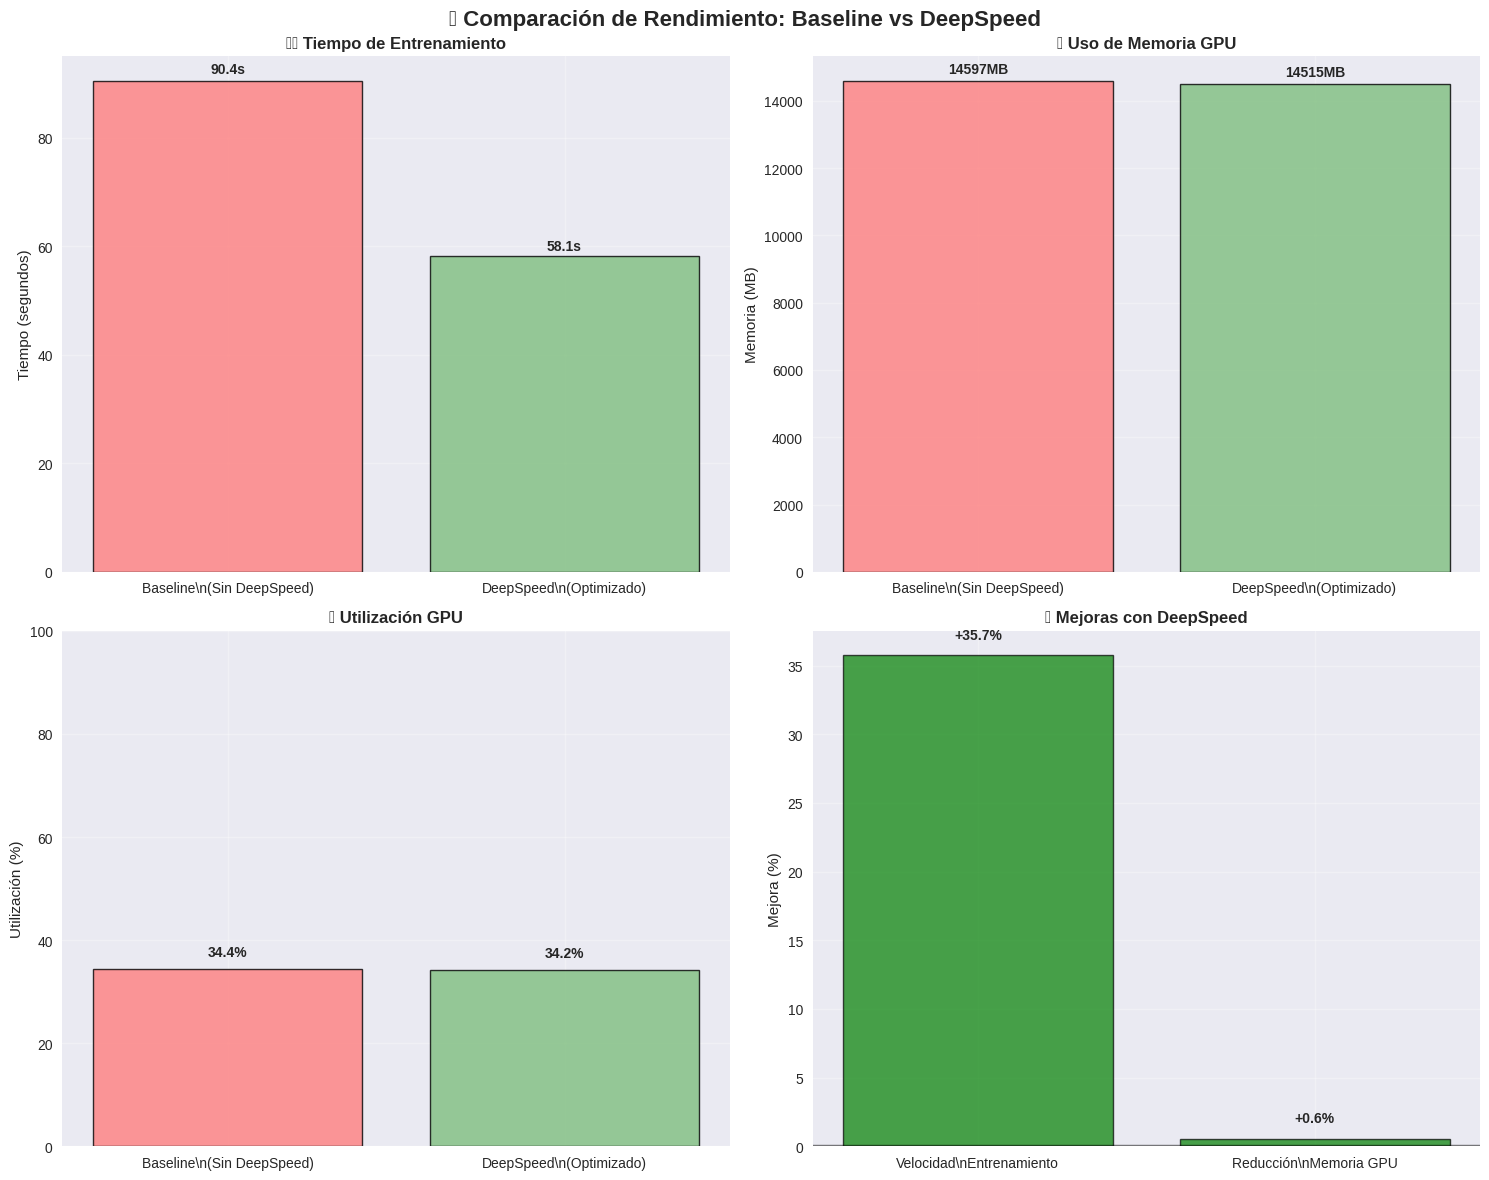


⚠️  No se pudieron generar gráficos de línea temporal: No hay datos de monitoreo detallados.


In [59]:
# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🚀 Comparación de Rendimiento: Baseline vs DeepSpeed', fontsize=16, fontweight='bold')

# 1. Tiempo de entrenamiento
ax1 = axes[0, 0]
methods = ['Baseline\\n(Sin DeepSpeed)', 'DeepSpeed\\n(Optimizado)']
times = [baseline_metrics['total_training_time'], deepspeed_metrics['total_training_time']]
colors = ['#ff7f7f', '#7fbf7f']

bars1 = ax1.bar(methods, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('⏱️ Tiempo de Entrenamiento', fontweight='bold')
ax1.set_ylabel('Tiempo (segundos)')
ax1.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, time in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

# 2. Memoria GPU
ax2 = axes[0, 1]
memory_usage = [baseline_metrics['avg_gpu_memory'], deepspeed_metrics['avg_gpu_memory']]

bars2 = ax2.bar(methods, memory_usage, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('🎯 Uso de Memoria GPU', fontweight='bold')
ax2.set_ylabel('Memoria (MB)')
ax2.grid(True, alpha=0.3)

for bar, memory in zip(bars2, memory_usage):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{memory:.0f}MB', ha='center', va='bottom', fontweight='bold')

# 3. Utilización GPU
ax3 = axes[1, 0]
gpu_util = [baseline_metrics['avg_gpu_utilization'], deepspeed_metrics['avg_gpu_utilization']]

bars3 = ax3.bar(methods, gpu_util, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_title('📈 Utilización GPU', fontweight='bold')
ax3.set_ylabel('Utilización (%)')
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)

for bar, util in zip(bars3, gpu_util):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{util:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Gráfico de mejoras
ax4 = axes[1, 1]
improvement_metrics = ['Velocidad\\nEntrenamiento', 'Reducción\\nMemoria GPU']
improvement_values = [improvements['time_speedup'], improvements['memory_reduction']]
improvement_colors = ['green' if x > 0 else 'red' for x in improvement_values]

bars4 = ax4.bar(improvement_metrics, improvement_values, color=improvement_colors, alpha=0.7, edgecolor='black', linewidth=1)
ax4.set_title('🏆 Mejoras con DeepSpeed', fontweight='bold')
ax4.set_ylabel('Mejora (%)')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

for bar, improvement in zip(bars4, improvement_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
             f'{improvement:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico de línea temporal para memoria GPU
# Add checks to ensure detailed metrics are not empty lists and contain required keys
if baseline_detailed and deepspeed_detailed and 'timestamps' in baseline_detailed[0] and 'timestamps' in deepspeed_detailed[0] and 'gpu_memory_used' in baseline_detailed[0] and 'gpu_memory_used' in deepspeed_detailed[0]:
    # Extract data from list of dictionaries
    baseline_timestamps = [m['timestamp'] for m in baseline_detailed]
    baseline_gpu_memory = [m['gpu_memory'] for m in baseline_detailed]
    deepspeed_timestamps = [m['timestamp'] for m in deepspeed_detailed]
    deepspeed_gpu_memory = [m['gpu_memory'] for m in deepspeed_detailed]

    if baseline_timestamps and deepspeed_timestamps: # Check if lists are not empty after extraction
        plt.figure(figsize=(12, 6))

        plt.plot(baseline_timestamps, baseline_gpu_memory,
                 label='Baseline (Sin DeepSpeed)', color='red', linewidth=2, alpha=0.8)
        plt.plot(deepspeed_timestamps, deepspeed_gpu_memory,
                 label='DeepSpeed (Optimizado)', color='green', linewidth=2, alpha=0.8)

        plt.title('📈 Uso de Memoria GPU Durante el Entrenamiento', fontsize=14, fontweight='bold')
        plt.xlabel('Tiempo (segundos)')
        plt.ylabel('Memoria GPU (MB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️  No se pudieron generar gráficos de línea temporal: No hay datos de monitoreo detallados.")
else:
    print("\n⚠️  No se pudieron generar gráficos de línea temporal: No hay datos de monitoreo detallados.")